In [ ]:
pip install mplfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Necessary imports for this project
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import mplfinance as mpf
import warnings
from IPython.display import display # Import the display function

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
# Loading the newly uploaded data
file_path = 'bitcoin_2017-09-07_2024-09-15.csv'
btc_df = pd.read_csv(file_path)

# Displaying the first few rows to understand its structure
btc_df.head()


,Start,End,Open,High,Low,Close,Volume,Market Cap
0,2017-09-07,2017-09-08,4597.12,4655.04,4491.33,4603.03,1.932914e+09,7.558147e+10
1,2017-09-08,2017-09-09,4599.88,4661.00,4075.18,4224.81,1.993160e+09,7.374856e+10
2,2017-09-09,2017-09-10,4228.75,4308.82,4114.11,4232.76,2.366425e+09,6.979280e+10
3,2017-09-10,2017-09-11,4226.06,4245.44,3951.04,4122.58,1.517856e+09,6.803915e+10
4,2017-09-11,2017-09-12,4122.94,4261.67,4099.40,4163.20,1.617782e+09,6.898337e+10


In [ ]:
# Function to identify if there's an uptrend or downtrend using a simple moving average (SMA)
def get_trend(prices, window=5):
    """Determine the trend based on the simple moving average (SMA).
    Returns "uptrend", "downtrend", or "neutral".
    """
    sma = prices.rolling(window=window).mean()
    trend = ["neutral"]  # Initialize first entry as neutral

    for i in range(1, len(prices)):
        if sma[i] > sma[i-1]:  # SMA is increasing
            trend.append("uptrend")
        elif sma[i] < sma[i-1]:  # SMA is decreasing
            trend.append("downtrend")
        else:
            trend.append("neutral")

    return trend

# Calculate the trend based on the 'Close' prices
btc_df['Trend'] = get_trend(btc_df['Close'])

# Enhanced labeling with refined definitions and trend incorporation
patterns = ['Unknown']  # Initialize the first entry as 'Unknown' since it lacks a previous day to compare with

for i in range(1, len(btc_df)):
    open_price = btc_df['Open'][i]
    close_price = btc_df['Close'][i]
    high_price = btc_df['High'][i]
    low_price = btc_df['Low'][i]
    prev_open = btc_df['Open'][i-1]
    prev_close = btc_df['Close'][i-1]
    trend = btc_df['Trend'][i]

    # Doji: Open and close are almost equal
    if abs(close_price - open_price) <= (high_price - low_price) * 0.1:
        patterns.append('DOJI')

    # Spinning Top: Small body with long upper and lower shadows
    elif (high_price - low_price) > 3 * abs(close_price - open_price) and \
         abs(high_price - close_price) > abs(open_price - close_price) and \
         abs(close_price - low_price) > abs(open_price - close_price):
        patterns.append('SPINNING TOP')

    # Hammer: Small body with a long lower wick, after a downtrend
    elif trend == "downtrend" and (high_price - low_price) > 2 * abs(close_price - open_price) and \
         (close_price - low_price) > 2 * (high_price - close_price):
        patterns.append('HAMMER')

    # Hanging Man: Small body with a long lower wick, after an uptrend
    elif trend == "uptrend" and (high_price - low_price) > 2 * abs(close_price - open_price) and \
         (close_price - low_price) > 2 * (high_price - close_price):
        patterns.append('HANGING MAN')

    # Shooting Star: Small body with a long upper wick, after an uptrend
    elif trend == "uptrend" and (high_price - low_price) > 2 * abs(open_price - close_price) and \
         (high_price - close_price) > 2 * abs(close_price - low_price):
        patterns.append('SHOOTING STAR')

    # Inverted Hammer: Small body with a long upper wick, after a downtrend
    elif trend == "downtrend" and (high_price - low_price) > 2 * abs(close_price - open_price) and \
         (high_price - close_price) > 2 * abs(close_price - low_price):
        patterns.append('INVERTED HAMMER')

    # Dragonfly Doji: Long lower wick, open and close near the high
    elif abs(close_price - open_price) <= (high_price - low_price) * 0.1 and \
         (high_price - open_price) <= (high_price - low_price) * 0.1:
        patterns.append('DRAGONFLY DOJI')

    # Gravestone Doji: Long upper wick, open and close near the low
    elif abs(close_price - open_price) <= (high_price - low_price) * 0.1 and \
         (open_price - low_price) <= (high_price - low_price) * 0.1:
        patterns.append('GRAVESTONE DOJI')

    # Bullish Engulfing: Current candle's body engulfs the previous candle's body, after a downtrend
    elif trend == "downtrend" and close_price > open_price and open_price < prev_close and close_price > prev_open:
        patterns[i-1] = 'BULLISH ENGULFING'  # Mark the previous day
        patterns.append('BULLISH ENGULFING')

    # Bearish Engulfing: Current candle's body engulfs the previous candle's body, after an uptrend
    elif trend == "uptrend" and close_price < open_price and open_price > prev_close and close_price < prev_open:
        patterns[i-1] = 'BEARISH ENGULFING'  # Mark the previous day
        patterns.append('BEARISH ENGULFING')

    # Piercing Line: Close of the second day is more than halfway up the previous red candle, after a downtrend
    elif trend == "downtrend" and close_price > open_price and open_price < prev_close and \
         close_price > (prev_open + prev_close) / 2:
        patterns[i-1] = 'PIERCING LINE'  # Mark the previous day
        patterns.append('PIERCING LINE')

    # Dark Cloud Cover: Close of the second day is more than halfway down the previous green candle, after an uptrend
    elif trend == "uptrend" and close_price < open_price and open_price > prev_close and \
         close_price < (prev_open + prev_close) / 2:
        patterns[i-1] = 'DARK CLOUD COVER'  # Mark the previous day
        patterns.append('DARK CLOUD COVER')

    # Morning Star: Three-day pattern indicating a bullish reversal, after a downtrend
    elif i >= 2 and trend == "downtrend" and close_price > open_price and prev_close < prev_open and \
         close_price > btc_df['Close'][i-2]:
        patterns[i-2] = 'MORNING STAR'  # Mark the day before the previous
        patterns[i-1] = 'MORNING STAR'  # Mark the previous day
        patterns.append('MORNING STAR')

    # Evening Star: Three-day pattern indicating a bearish reversal, after an uptrend
    elif i >= 2 and trend == "uptrend" and close_price < open_price and prev_close > prev_open and \
         close_price < btc_df['Close'][i-2]:
        patterns[i-2] = 'EVENING STAR'  # Mark the day before the previous
        patterns[i-1] = 'EVENING STAR'  # Mark the previous day
        patterns.append('EVENING STAR')

    # Morning Doji Star: Similar to Morning Star but with a Doji on the second day
    elif i >= 2 and trend == "downtrend" and abs(prev_close - prev_open) <= (btc_df['High'][i-1] - btc_df['Low'][i-1]) * 0.1 and \
         close_price > open_price and close_price > btc_df['Close'][i-2]:
        patterns[i-2] = 'MORNING DOJI STAR'
        patterns[i-1] = 'MORNING DOJI STAR'
        patterns.append('MORNING DOJI STAR')

    # Evening Doji Star: Similar to Evening Star but with a Doji on the second day
    elif i >= 2 and trend == "uptrend" and abs(prev_close - prev_open) <= (btc_df['High'][i-1] - btc_df['Low'][i-1]) * 0.1 and \
         close_price < open_price and close_price < btc_df['Close'][i-2]:
        patterns[i-2] = 'EVENING DOJI STAR'
        patterns[i-1] = 'EVENING DOJI STAR'
        patterns.append('EVENING DOJI STAR')

    # Three White Soldiers: Three consecutive bullish candles with higher closes, indicating a strong uptrend
    elif i >= 2 and trend == "downtrend" and close_price > open_price and prev_close > prev_open and \
         btc_df['Close'][i-2] > btc_df['Open'][i-2]:
        patterns[i-2] = 'THREE WHITE SOLDIERS'
        patterns[i-1] = 'THREE WHITE SOLDIERS'
        patterns.append('THREE WHITE SOLDIERS')

    # Three Black Crows: Three consecutive bearish candles with lower closes, indicating a strong downtrend
    elif i >= 2 and trend == "uptrend" and close_price < open_price and prev_close < prev_open and \
         btc_df['Close'][i-2] < btc_df['Open'][i-2]:
        patterns[i-2] = 'THREE BLACK CROWS'
        patterns[i-1] = 'THREE BLACK CROWS'
        patterns.append('THREE BLACK CROWS')

    else:
        patterns.append('Unknown')

# Updating the DataFrame with the new pattern labels
btc_df['Candlestick Pattern'] = patterns

# Displaying the updated DataFrame to the user
btc_df.head()
#btc_df.to_csv('refined_candlestick_patterns.csv', index=False)


,Start,End,Open,High,Low,Close,Volume,Market Cap,Trend,Candlestick Pattern
0,2017-09-07,2017-09-08,4597.12,4655.04,4491.33,4603.03,1.932914e+09,7.558147e+10,neutral,Unknown
1,2017-09-08,2017-09-09,4599.88,4661.00,4075.18,4224.81,1.993160e+09,7.374856e+10,neutral,Unknown
2,2017-09-09,2017-09-10,4228.75,4308.82,4114.11,4232.76,2.366425e+09,6.979280e+10,neutral,DOJI
3,2017-09-10,2017-09-11,4226.06,4245.44,3951.04,4122.58,1.517856e+09,6.803915e+10,neutral,Unknown
4,2017-09-11,2017-09-12,4122.94,4261.67,4099.40,4163.20,1.617782e+09,6.898337e+10,neutral,SPINNING TOP


In [ ]:
# Function to identify the trend using a simple moving average (SMA)
def get_trend(prices, window=5):
    sma = prices.rolling(window=window).mean()
    trend = ["neutral"]  # Initialize the first entry as neutral

    for i in range(1, len(prices)):
        if sma[i] > sma[i - 1]:  # SMA is increasing
            trend.append("uptrend")
        elif sma[i] < sma[i - 1]:  # SMA is decreasing
            trend.append("downtrend")
        else:
            trend.append("neutral")

    return trend

# Calculate the trend based on the 'Close' prices
btc_df['Trend'] = get_trend(btc_df['Close'])

# Function to identify candlestick patterns, incorporating refined rules
def identify_candlestick_patterns(df):
    patterns = ['Unknown']  # Initialize the first entry as 'Unknown'

    for i in range(1, len(df)):
        open_price = df['Open'][i]
        close_price = df['Close'][i]
        high_price = df['High'][i]
        low_price = df['Low'][i]
        prev_open = df['Open'][i - 1]
        prev_close = df['Close'][i - 1]
        trend = df['Trend'][i]

        # Body size and wick calculations
        body_size = abs(close_price - open_price)
        upper_wick = high_price - max(open_price, close_price)
        lower_wick = min(open_price, close_price) - low_price
        candle_range = high_price - low_price

        # 1. Doji: Open and close are almost equal
        if body_size <= candle_range * 0.1:
            patterns.append('DOJI')

        # 2. Spinning Top: Small body with long upper and lower shadows
        elif body_size <= candle_range * 0.3 and upper_wick > body_size and lower_wick > body_size:
            patterns.append('SPINNING TOP')

        # 3. Hammer: Small body near the top, long lower wick, after a downtrend
        elif trend == "downtrend" and body_size <= candle_range * 0.3 and lower_wick >= 2 * body_size and upper_wick <= body_size * 0.1:
            patterns.append('HAMMER')

        # 4. Hanging Man: Similar to the Hammer but occurs after an uptrend
        elif trend == "uptrend" and body_size <= candle_range * 0.3 and lower_wick >= 2 * body_size and upper_wick <= body_size * 0.1:
            patterns.append('HANGING MAN')

        # 5. Shooting Star: Small body near the bottom, long upper wick, after an uptrend
        elif trend == "uptrend" and body_size <= candle_range * 0.3 and upper_wick >= 2 * body_size and lower_wick <= body_size * 0.1:
            patterns.append('SHOOTING STAR')

        # 6. Inverted Hammer: Similar to the Shooting Star but occurs after a downtrend
        elif trend == "downtrend" and body_size <= candle_range * 0.3 and upper_wick >= 2 * body_size and lower_wick <= body_size * 0.1:
            patterns.append('INVERTED HAMMER')

        # 7. Dragonfly Doji: Long lower wick, open and close near the high
        elif body_size <= candle_range * 0.1 and lower_wick >= 2 * body_size and upper_wick <= candle_range * 0.1:
            patterns.append('DRAGONFLY DOJI')

        # 8. Gravestone Doji: Long upper wick, open and close near the low
        elif body_size <= candle_range * 0.1 and upper_wick >= 2 * body_size and lower_wick <= candle_range * 0.1:
            patterns.append('GRAVESTONE DOJI')

        # 9. Bullish Engulfing: Current candle's body engulfs the previous candle's body, after a downtrend
        elif trend == "downtrend" and close_price > open_price and open_price < prev_close and close_price > prev_open and \
             body_size > abs(prev_close - prev_open):
            patterns[i - 1] = 'BULLISH ENGULFING'
            patterns.append('BULLISH ENGULFING')

        # 10. Bearish Engulfing: Current candle's body engulfs the previous candle's body, after an uptrend
        elif trend == "uptrend" and close_price < open_price and open_price > prev_close and close_price < prev_open and \
             body_size > abs(prev_open - prev_close):
            patterns[i - 1] = 'BEARISH ENGULFING'
            patterns.append('BEARISH ENGULFING')

        # 11. Piercing Line: Second candle closes more than halfway up the previous red candle, after a downtrend
        elif trend == "downtrend" and close_price > open_price and open_price < prev_close and \
             close_price > (prev_open + prev_close) / 2:
            patterns[i - 1] = 'PIERCING LINE'
            patterns.append('PIERCING LINE')

        # 12. Dark Cloud Cover: Second candle closes more than halfway down the previous green candle, after an uptrend
        elif trend == "uptrend" and close_price < open_price and open_price > prev_close and \
             close_price < (prev_open + prev_close) / 2:
            patterns[i - 1] = 'DARK CLOUD COVER'
            patterns.append('DARK CLOUD COVER')

        # 13. Morning Star: Three-day pattern indicating a bullish reversal, after a downtrend
        elif i >= 2 and trend == "downtrend" and close_price > open_price and prev_close < prev_open and \
             close_price > (df['Close'][i-2] + df['Open'][i-2]) / 2:
            patterns[i - 2] = 'MORNING STAR'
            patterns[i - 1] = 'MORNING STAR'
            patterns.append('MORNING STAR')

        # 14. Evening Star: Three-day pattern indicating a bearish reversal, after an uptrend
        elif i >= 2 and trend == "uptrend" and close_price < open_price and prev_close > prev_open and \
             close_price < (df['Close'][i-2] + df['Open'][i-2]) / 2:
            patterns[i - 2] = 'EVENING STAR'
            patterns[i - 1] = 'EVENING STAR'
            patterns.append('EVENING STAR')

        # 15. Morning Doji Star: Similar to Morning Star but with a Doji on the second day
        elif i >= 2 and trend == "downtrend" and abs(prev_close - prev_open) <= (df['High'][i-1] - df['Low'][i-1]) * 0.1 and \
             close_price > open_price and close_price > df['Close'][i-2]:
            patterns[i - 2] = 'MORNING DOJI STAR'
            patterns[i - 1] = 'MORNING DOJI STAR'
            patterns.append('MORNING DOJI STAR')

        # 16. Evening Doji Star: Similar to Evening Star but with a Doji on the second day
        elif i >= 2 and trend == "uptrend" and abs(prev_close - prev_open) <= (df['High'][i-1] - df['Low'][i-1]) * 0.1 and \
             close_price < open_price and close_price < df['Close'][i-2]:
            patterns[i - 2] = 'EVENING DOJI STAR'
            patterns[i - 1] = 'EVENING DOJI STAR'
            patterns.append('EVENING DOJI STAR')

        # 17. Three White Soldiers: Three consecutive bullish candles with higher opens and closes, indicating a strong uptrend
        elif i >= 2 and trend == "downtrend" and close_price > open_price and prev_close > prev_open and \
             df['Close'][i-2] > df['Open'][i-2] and df['Open'][i] > df['Close'][i-1] and df['Open'][i-1] > df['Close'][i-2] and \
             close_price > prev_close and prev_close > df['Close'][i-2]:
            patterns[i - 2] = 'THREE WHITE SOLDIERS'
            patterns[i - 1] = 'THREE WHITE SOLDIERS'
            patterns.append('THREE WHITE SOLDIERS')

        # 18. Three Black Crows: Three consecutive bearish candles with lower opens and closes, indicating a strong downtrend
        elif i >= 2 and trend == "uptrend" and close_price < open_price and prev_close < prev_open and \
             df['Close'][i-2] < df['Open'][i-2] and df['Open'][i] < df['Close'][i-1] and df['Open'][i-1] < df['Close'][i-2] and \
             close_price < prev_close and prev_close < df['Close'][i-2]:
            patterns[i-2] = 'THREE BLACK CROWS'
            patterns[i-1] = 'THREE BLACK CROWS'
            patterns.append('THREE BLACK CROWS')

    else:
        patterns.append('Unknown')

# Updating the DataFrame with the new pattern labels
btc_df['Candlestick Pattern'] = patterns

# Displaying the updated DataFrame to the user
btc_df.head()
btc_df.to_csv('refined_candlestick_patterns1.csv', index=False)

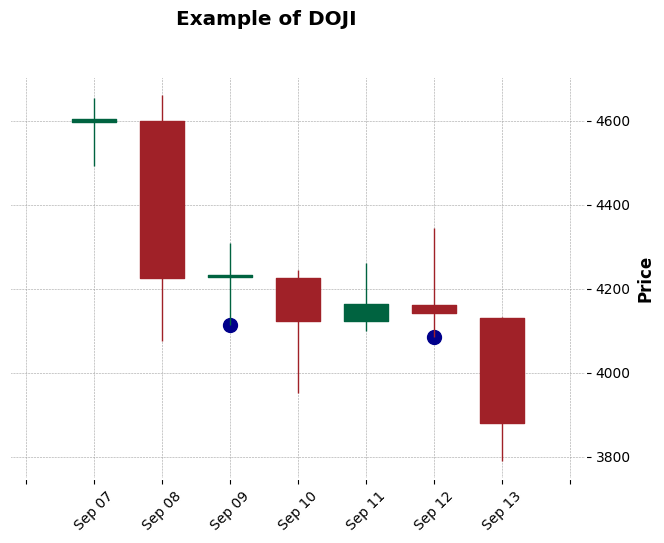

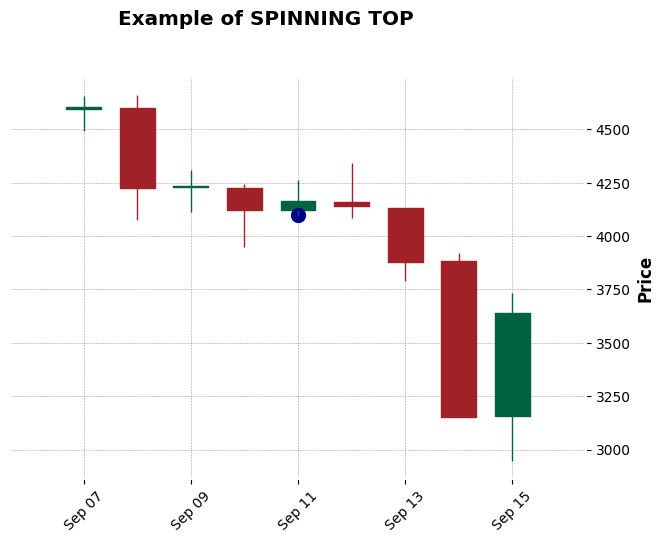

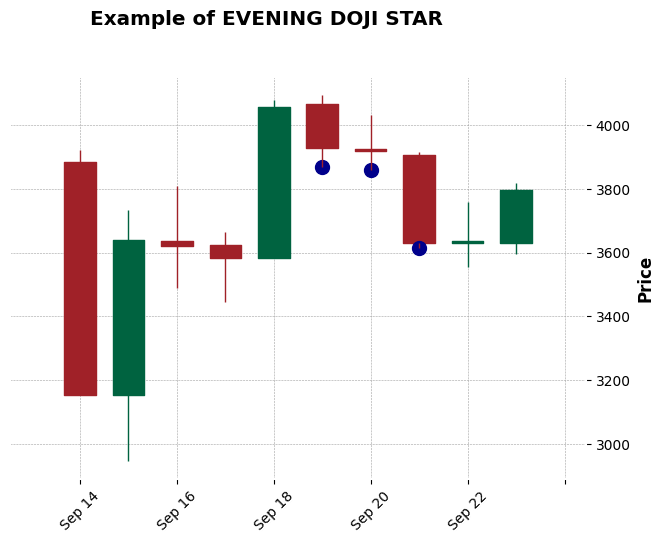

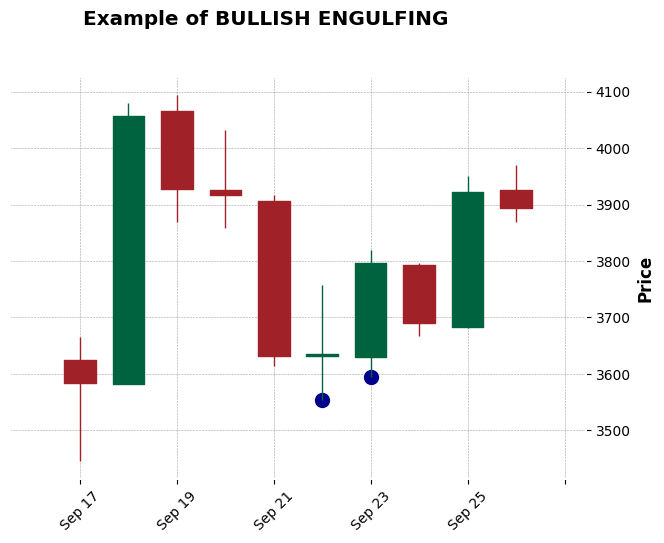

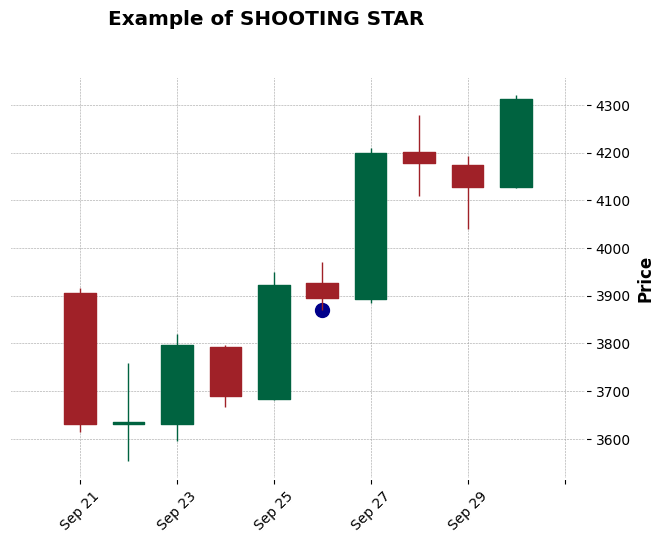

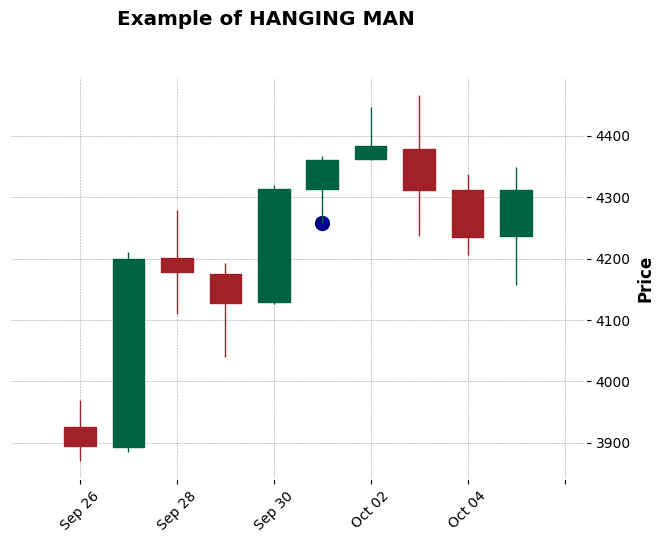

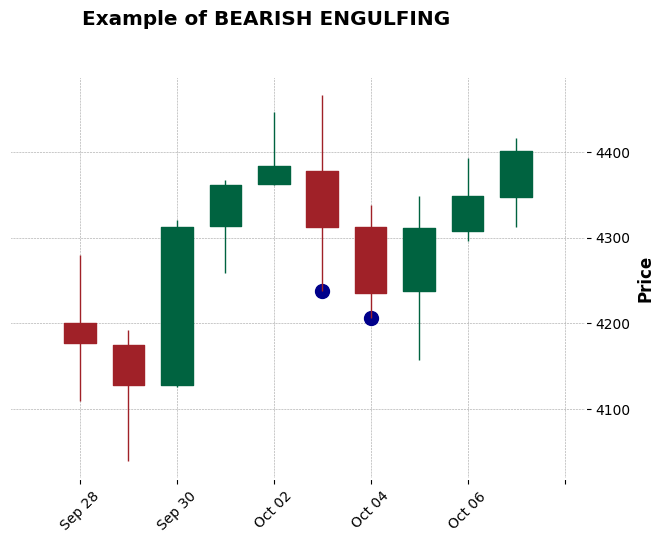

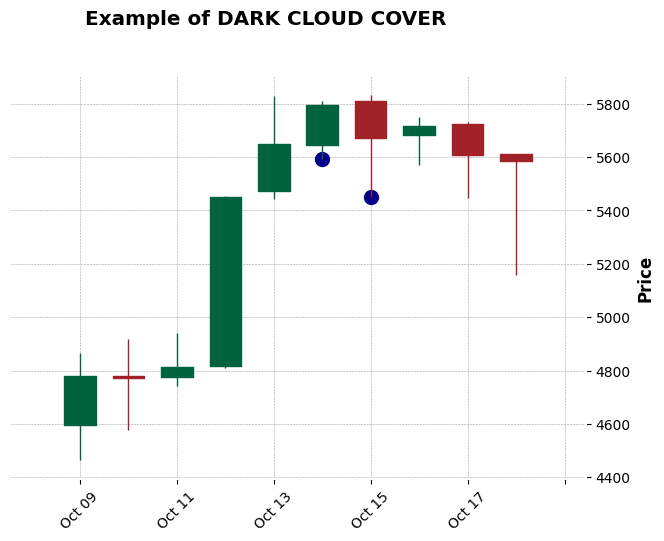

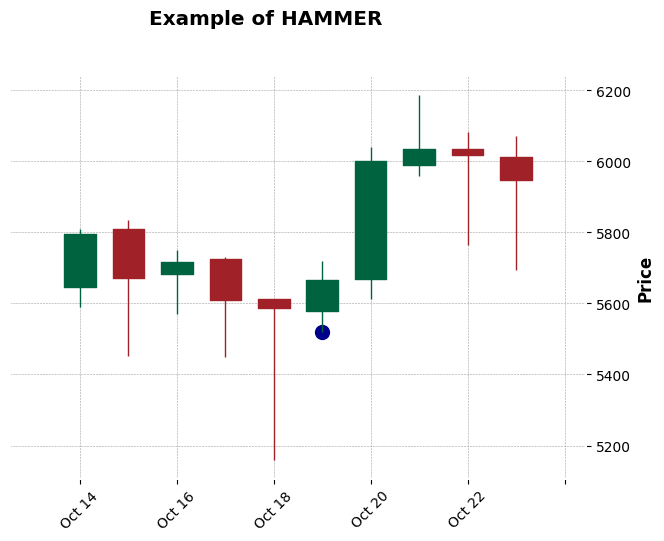

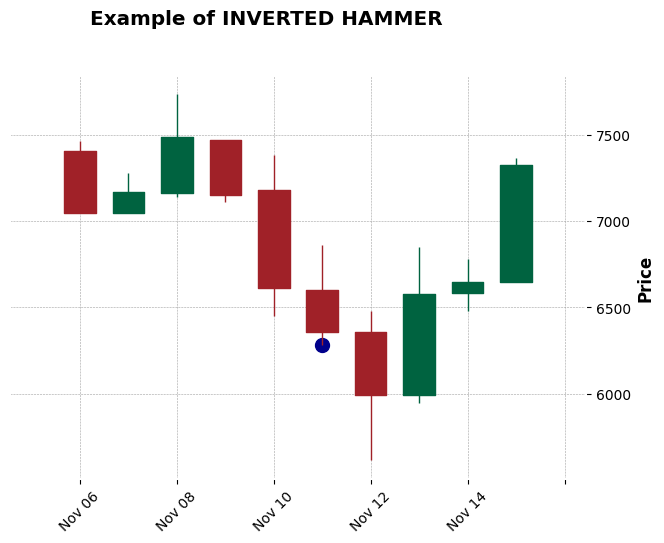

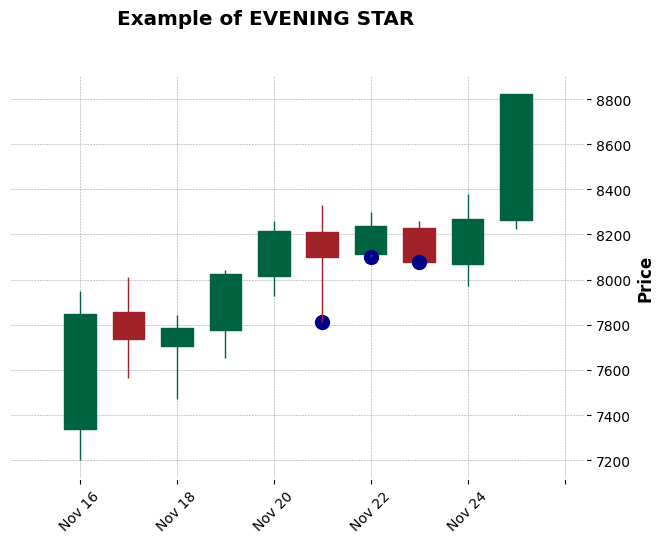

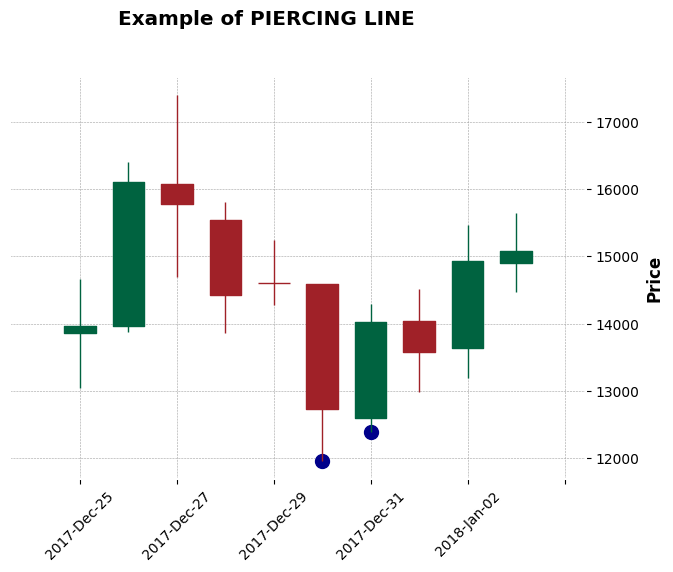

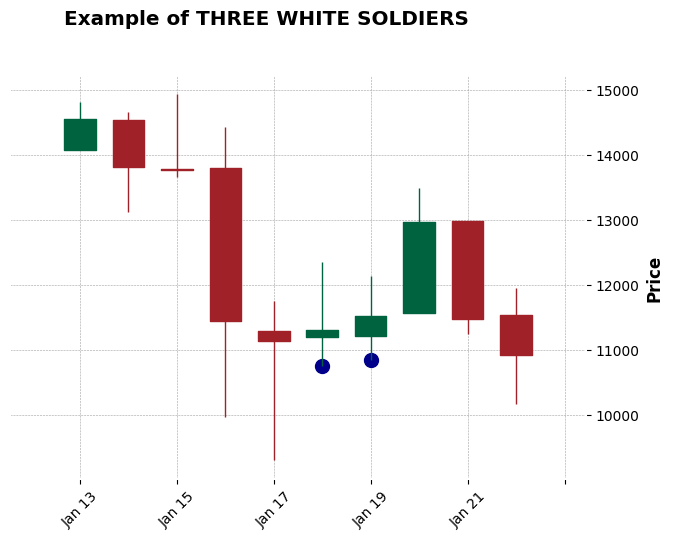

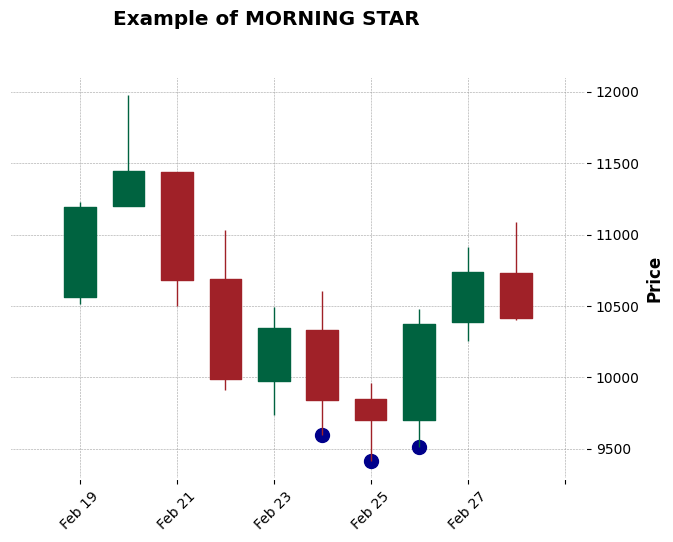

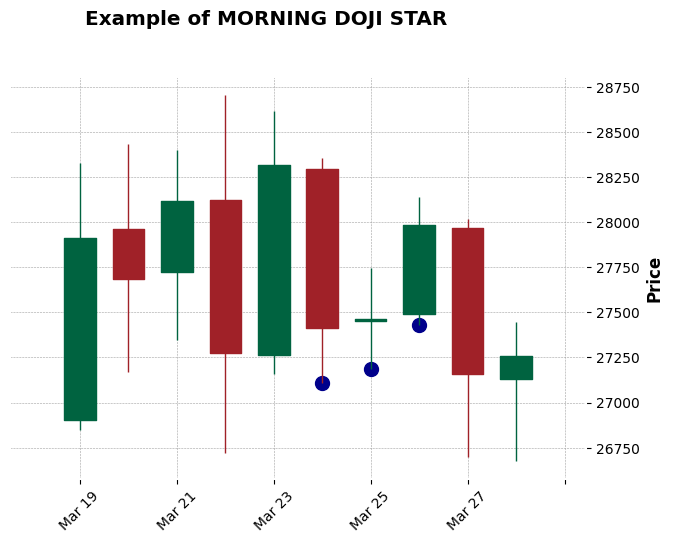

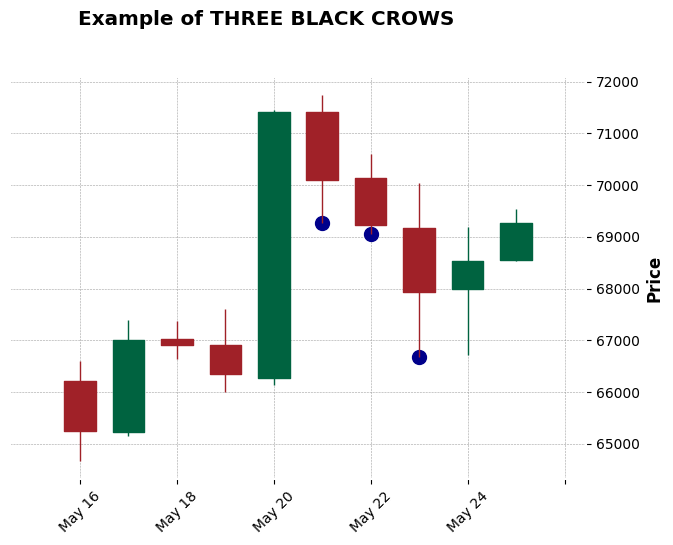

In [ ]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

# Function to visualize one example of each pattern in the dataset
def plot_candlestick_examples(df):
    unique_patterns = df['Candlestick Pattern'].unique()

    for pattern_label in unique_patterns:
        # Skip "Unknown" patterns for plotting clarity
        if pattern_label == 'Unknown':
            continue

        # Select one example of the current pattern
        examples = df[df['Candlestick Pattern'] == pattern_label]
        if not examples.empty:
            example_index = examples.index[0]

            # Define a window around the pattern to provide context
            start_index = max(0, example_index - 5)
            end_index = min(len(df), example_index + 5)

            # Extract the data for plotting
            plot_data = df.iloc[start_index:end_index].copy()
            plot_data.index = pd.to_datetime(plot_data['Start'])

            # Create a series for highlighting: np.nan for non-matching candles, the 'Low' value for matching candles
            highlight_values = [
                plot_data['Low'][idx] if plot_data['Candlestick Pattern'][idx] == pattern_label else np.nan
                for idx in plot_data.index
            ]

            # Create the addplot object to highlight the candles
            highlight = mpf.make_addplot(highlight_values, type='scatter', markersize=100, marker='o', color='darkblue')

            # Plotting the example with highlighted markers
            title = f"Example of {pattern_label}"
            mpf.plot(plot_data[['Open', 'High', 'Low', 'Close']], type='candle', style='charles', title=title, volume=False, addplot=highlight)
            plt.show()

# Visualize one example for each pattern in the labeled dataset
plot_candlestick_examples(btc_df)


In [ ]:
btc_df["Candlestick Pattern"].value_counts()

,count
Candlestick Pattern,
Unknown,999
SPINNING TOP,413
DOJI,199
BULLISH ENGULFING,139
BEARISH ENGULFING,137
HANGING MAN,117
EVENING STAR,115
HAMMER,87
MORNING STAR,86


In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Assuming `btc_df` has been preprocessed and has features + 'Candlestick Pattern' column

# Feature extraction (e.g., OHLC ratios)
btc_df['range'] = btc_df['High'] - btc_df['Low']
btc_df['body'] = abs(btc_df['Close'] - btc_df['Open'])
features = btc_df[['Open', 'High', 'Low', 'Close', 'Volume', 'range', 'body']]

# Encode labels
labels = btc_df['Candlestick Pattern'].astype('category').cat.codes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5298701298701298
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.06      0.09        35
           1       0.10      0.02      0.04        41
           2       1.00      0.11      0.20        18
           3       0.74      0.87      0.80        61
           4       0.00      0.00      0.00         7
           5       0.27      0.10      0.15        39
           6       0.00      0.00      0.00        30
           7       0.25      0.06      0.09        36
           8       0.00      0.00      0.00        18
          10       0.00      0.00      0.00        38
          11       0.33      0.09      0.14        11
          12       0.00      0.00      0.00        22
          13       0.50      0.74      0.60       117
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         5
          16       0.57      0.88      0.69       291

    accuracy               

In [ ]:
#autoencoder+MLP
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras import layers, models
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assume btc_df is the DataFrame with the labeled candlestick patterns
# Prepare the features and labels for the model
btc_df['range'] = btc_df['High'] - btc_df['Low']
btc_df['body'] = abs(btc_df['Close'] - btc_df['Open'])
features = btc_df[['Open', 'High', 'Low', 'Close', 'Volume', 'range', 'body']]

# Encode labels for classification
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(btc_df['Candlestick Pattern'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 1: Build the Autoencoder for Feature Extraction
input_dim = X_train_scaled.shape[1]  # Number of features
encoding_dim = 5  # Compressing to 5 features

# Define the autoencoder model
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

# Compile the autoencoder
autoencoder = models.Model(input_layer, decoded)
encoder = models.Model(input_layer, encoded)  # For feature extraction
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=16, shuffle=True, validation_data=(X_test_scaled, X_test_scaled))

# Step 2: Extract Features Using the Encoder
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Step 3: Use MLP Classifier with Encoded Features
mlp_classifier = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42)
mlp_classifier.fit(X_train_encoded, y_train)

# Make predictions and evaluate the model
y_pred = mlp_classifier.predict(X_test_encoded)

# Get the unique classes in y_test to match the labels in the classification report
unique_classes_in_test = np.unique(y_test)

# Step 4: Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(unique_classes_in_test), labels=unique_classes_in_test))

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1202 - val_loss: 0.0966
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0913 - val_loss: 0.0749
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0710 - val_loss: 0.0570
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0544 - val_loss: 0.0411
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0392 - val_loss: 0.0284
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266 - val_loss: 0.0193
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185 - val_loss: 0.0132
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - val_loss: 0.0095
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - val_loss: 0.0072
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [ ]:
#lstm+cnn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, accuracy_score

# Assume btc_df is the DataFrame with the labeled candlestick patterns
# Prepare the features and labels for the model
btc_df['range'] = btc_df['High'] - btc_df['Low']
btc_df['body'] = abs(btc_df['Close'] - btc_df['Open'])
features = btc_df[['Open', 'High', 'Low', 'Close', 'Volume', 'range', 'body']]

# Encode labels for classification
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(btc_df['Candlestick Pattern'])

# Prepare sequences for CNN-LSTM (e.g., 10-candle sequences)
sequence_length = 10

# Helper function to create sequences
def create_sequences(features, labels, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])
        y.append(labels[i + sequence_length])
    return np.array(X), np.array(y)

# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences for training
X, y = create_sequences(features_scaled, labels, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 1: Build the CNN-LSTM Model
model = models.Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.LSTM(50, return_sequences=False))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(len(np.unique(labels)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 2: Train the CNN-LSTM Model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# Step 3: Make Predictions and Evaluate the Model

y_pred = np.argmax(model.predict(X_test), axis=1)

# Get unique classes in y_test to ensure the report contains only relevant classes
unique_classes_in_test = np.unique(y_test)

# Step 4: Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, labels=unique_classes_in_test, target_names=label_encoder.inverse_transform(unique_classes_in_test)))



Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3689 - loss: 2.5580 - val_accuracy: 0.3715 - val_loss: 2.2067
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3853 - loss: 2.1525 - val_accuracy: 0.3715 - val_loss: 2.1815
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3990 - loss: 2.0382 - val_accuracy: 0.3715 - val_loss: 2.1646
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3826 - loss: 2.1101 - val_accuracy: 0.3715 - val_loss: 2.1640
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4013 - loss: 2.0676 - val_accuracy: 0.3715 - val_loss: 2.1660
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4000 - loss: 2.0976 - val_accuracy: 0.3715 - val_loss: 2.1669
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3888 - loss: 2.0795 - val_accuracy: 0.3715 - val_loss: 2.1571
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3716 - loss: 2.1238 - val_accuracy: 0.3715 - val_loss

In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
import keras_tuner as kt

# Assuming btc_df is the DataFrame with the labeled candlestick patterns
# Step 1: Add custom technical indicators
def compute_sma(data, window):
    return data.rolling(window=window).mean()

def compute_ema(data, window):
    return data.ewm(span=window, adjust=False).mean()

def compute_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Adding custom indicators to the DataFrame
btc_df['SMA_10'] = compute_sma(btc_df['Close'], 10)
btc_df['EMA_10'] = compute_ema(btc_df['Close'], 10)
btc_df['RSI'] = compute_rsi(btc_df['Close'], 14)

# Prepare features including the new indicators
btc_df['range'] = btc_df['High'] - btc_df['Low']
btc_df['body'] = abs(btc_df['Close'] - btc_df['Open'])
features = btc_df[['Open', 'High', 'Low', 'Close', 'Volume', 'range', 'body', 'SMA_10', 'EMA_10', 'RSI']]

# Encode labels for classification
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(btc_df['Candlestick Pattern'])

# Step 2: Create sequences for CNN-LSTM (e.g., 10-candle sequences)
sequence_length = 10

def create_sequences(features, labels, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])
        y.append(labels[i + sequence_length])
    return np.array(X), np.array(y)

# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences for training
X, y = create_sequences(features_scaled, labels, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Define a hypermodel using Keras Tuner
def build_model(hp):
    model = models.Sequential()
    # Hyperparameters for Conv1D
    model.add(layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=(sequence_length, X.shape[2])
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Hyperparameters for LSTM
    model.add(layers.LSTM(hp.Int('lstm_units', min_value=50, max_value=200, step=50), return_sequences=False))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Dense layers
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(len(np.unique(labels)), activation='softmax'))

    # Hyperparameter for learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Step 4: Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of times to train the model for each trial to get an average result
    directory='hyperparameter_tuning',
    project_name='cnn_lstm_tuning'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 5: Run hyperparameter search
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Step 6: Build and train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Step 7: Make predictions and evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=1)

# Report the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, labels=np.unique(y_test), target_names=label_encoder.inverse_transform(np.unique(y_test))))


Trial 10 Complete [00h 00m 15s]
val_accuracy: 0.05027933046221733

Best val_accuracy So Far: 0.05027933046221733
Total elapsed time: 00h 02m 41s
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.0592 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0551 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0486 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0555 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0510 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy: 0.0600
Classification Report:
                       precision    recall  f1-score   support

   BEARISH ENGULFING       0.06      1.00      0.11        46
   BULLISH ENGULFING       0.00      0.00      0

In [ ]:
# Adding Bollinger Bands and MACD
btc_df['BB_upper'] = btc_df['Close'].rolling(window=20).mean() + (btc_df['Close'].rolling(window=20).std() * 2)
btc_df['BB_lower'] = btc_df['Close'].rolling(window=20).mean() - (btc_df['Close'].rolling(window=20).std() * 2)
exp1 = btc_df['Close'].ewm(span=12, adjust=False).mean()
exp2 = btc_df['Close'].ewm(span=26, adjust=False).mean()
btc_df['MACD'] = exp1 - exp2
btc_df['Signal_Line'] = btc_df['MACD'].ewm(span=9, adjust=False).mean()

# Update features with new indicators
features = btc_df[['Open', 'High', 'Low', 'Close', 'Volume', 'range', 'body', 'SMA_10', 'EMA_10', 'RSI', 'BB_upper', 'BB_lower', 'MACD', 'Signal_Line']]

# Continue with the rest of the process
# Normalize, create sequences, split data...

# Longer sequence length
sequence_length = 20

# Model building remains the same...

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])

# Make predictions and evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, labels=np.unique(y_test), target_names=label_encoder.inverse_transform(np.unique(y_test))))


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0508 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0496 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0562 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0507 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0472 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.0600
Classification Report:
                       precision    recall  f1-score   support

   BEARISH ENGULFING       0.06      1.00      0.11        46
   BULLISH ENGULFING       0.00      0.00      0.00        34
    DARK CLOUD COVER       0.00      0.00      0.00        12
                DOJI       0.00      0.00      0.00        63
   EVENI

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight

# Assuming btc_df is the DataFrame with the labeled candlestick patterns
# Step 1: Add custom technical indicators (SMA, EMA, RSI, Bollinger Bands, MACD)
def compute_sma(data, window):
    return data.rolling(window=window).mean()

def compute_ema(data, window):
    return data.ewm(span=window, adjust=False).mean()

def compute_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Adding Bollinger Bands and MACD
btc_df['BB_upper'] = btc_df['Close'].rolling(window=20).mean() + (btc_df['Close'].rolling(window=20).std() * 2)
btc_df['BB_lower'] = btc_df['Close'].rolling(window=20).mean() - (btc_df['Close'].rolling(window=20).std() * 2)
exp1 = btc_df['Close'].ewm(span=12, adjust=False).mean()
exp2 = btc_df['Close'].ewm(span=26, adjust=False).mean()
btc_df['MACD'] = exp1 - exp2
btc_df['Signal_Line'] = btc_df['MACD'].ewm(span=9, adjust=False).mean()

# Adding the rest of the indicators
btc_df['SMA_10'] = compute_sma(btc_df['Close'], 10)
btc_df['EMA_10'] = compute_ema(btc_df['Close'], 10)
btc_df['RSI'] = compute_rsi(btc_df['Close'], 14)
btc_df['range'] = btc_df['High'] - btc_df['Low']
btc_df['body'] = abs(btc_df['Close'] - btc_df['Open'])

# Prepare features including all the new indicators
features = btc_df[['Open', 'High', 'Low', 'Close', 'Volume', 'range', 'body', 'SMA_10', 'EMA_10', 'RSI', 'BB_upper', 'BB_lower', 'MACD', 'Signal_Line']]

# Encode labels for classification
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(btc_df['Candlestick Pattern'])

# Step 2: Normalize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.3, random_state=42)

# Step 3: Handle class imbalance by computing class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Step 4: Hyperparameter tuning for Random Forest using RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best estimator
best_rf = random_search.best_estimator_

# Step 5: Evaluate the model on the test set
y_pred = best_rf.predict(X_test)

# Report the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, labels=np.unique(y_test), target_names=label_encoder.inverse_transform(np.unique(y_test))))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 96, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.

--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 96, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.

--------------------------------------------------------------------------------
185 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 957, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 122, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 171, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Simplified parameter space for debugging
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Reduced for debugging
    cv=3,  # Reduced number of folds for faster debugging
    verbose=2,
    n_jobs=-1,
    random_state=42,
    error_score='raise'  # Raise errors to identify the cause
)

# Fit the model
try:
    random_search.fit(X_train, y_train)

    # Get the best estimator
    best_rf = random_search.best_estimator_

    # Make predictions and evaluate the model
    y_pred = best_rf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Print classification report
    print("Classification Report:\n", classification_report(y_test, y_pred, labels=np.unique(y_test), target_names=label_encoder.inverse_transform(np.unique(y_test))))

    # Print the best hyperparameters
    print("Best Hyperparameters:", random_search.best_params_)

except ValueError as e:
    print(f"Error during fitting: {e}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Error during fitting: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, accuracy_score

# Assuming btc_df is the DataFrame with the labeled candlestick patterns
# Add custom technical indicators (SMA, EMA, RSI, Bollinger Bands, MACD)
def compute_sma(data, window):
    return data.rolling(window=window).mean()

def compute_ema(data, window):
    return data.ewm(span=window, adjust=False).mean()

def compute_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Adding Bollinger Bands and MACD
btc_df['BB_upper'] = btc_df['Close'].rolling(window=20).mean() + (btc_df['Close'].rolling(window=20).std() * 2)
btc_df['BB_lower'] = btc_df['Close'].rolling(window=20).mean() - (btc_df['Close'].rolling(window=20).std() * 2)
exp1 = btc_df['Close'].ewm(span=12, adjust=False).mean()
exp2 = btc_df['Close'].ewm(span=26, adjust=False).mean()
btc_df['MACD'] = exp1 - exp2
btc_df['Signal_Line'] = btc_df['MACD'].ewm(span=9, adjust=False).mean()

# Adding other indicators
btc_df['SMA_10'] = compute_sma(btc_df['Close'], 10)
btc_df['EMA_10'] = compute_ema(btc_df['Close'], 10)
btc_df['RSI'] = compute_rsi(btc_df['Close'], 14)
btc_df['range'] = btc_df['High'] - btc_df['Low']
btc_df['body'] = abs(btc_df['Close'] - btc_df['Open'])

# Prepare features including all the new indicators
features = btc_df[['Open', 'High', 'Low', 'Close', 'Volume', 'range', 'body', 'SMA_10', 'EMA_10', 'RSI', 'BB_upper', 'BB_lower', 'MACD', 'Signal_Line']]

# Encode labels for classification
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(btc_df['Candlestick Pattern'])

# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences for CNN (e.g., 10-candle sequences)
sequence_length = 10

def create_sequences(features, labels, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])
        y.append(labels[i + sequence_length])
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(features_scaled, labels, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Build the CNN model
model = models.Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(np.unique(labels)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the CNN model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Step 5: Make predictions and evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred, labels=np.unique(y_test), target_names=label_encoder.inverse_transform(np.unique(y_test))))


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1231 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0507 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0504 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0428 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0588 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0394 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0498 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0491 - loss: nan - val_accuracy: 0.0503 - val_loss: nan
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Feature Engineering: Adding Technical Indicators
def compute_sma(data, window):
    return data.rolling(window=window).mean()

def compute_ema(data, window):
    return data.ewm(span=window, adjust=False).mean()

def compute_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Assuming `btc_df` is the DataFrame with the preprocessed data
# Adding additional indicators: SMA, EMA, RSI
btc_df['SMA_10'] = compute_sma(btc_df['Close'], 10)
btc_df['EMA_10'] = compute_ema(btc_df['Close'], 10)
btc_df['RSI'] = compute_rsi(btc_df['Close'], 14)
btc_df['range'] = btc_df['High'] - btc_df['Low']
btc_df['body'] = abs(btc_df['Close'] - btc_df['Open'])

# Prepare the feature set
features = btc_df[['Open', 'High', 'Low', 'Close', 'Volume', 'range', 'body', 'SMA_10', 'EMA_10', 'RSI']]

# Handle missing values (if any) due to rolling computations
features.fillna(method='bfill', inplace=True)

# Encode labels
labels = btc_df['Candlestick Pattern'].astype('category').cat.codes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Feature Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_model = RandomForestClassifier(random_state=42)

# Using RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings sampled
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train_scaled, y_train)

# Get the best model from RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Make predictions with the best model
y_pred = best_rf_model.predict(X_test_scaled)

# Evaluate the model
print("Best Hyperparameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, labels=np.unique(y_test), target_names=label_encoder.inverse_transform(np.unique(y_test))))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Accuracy: 0.5493506493506494
Classification Report:
                       precision    recall  f1-score   support

   BEARISH ENGULFING       1.00      0.03      0.06        35
   BULLISH ENGULFING       0.00      0.00      0.00        41
    DARK CLOUD COVER       0.00      0.00      0.00        18
                DOJI       0.73      0.84      0.78        61
   EVENING DOJI STAR       0.00      0.00      0.00         7
        EVENING STAR       0.00      0.00      0.00        39
              HAMMER       0.00      0.00      0.00        30
         HANGING MAN       0.00      0.00      0.00        36
     INVERTED HAMMER       0.00      0.00      0.00        18
        MORNING STAR       0.00      0.00      0.00        38
       PIERCING LINE       0.00      0.00      0.00        11
       S